In [1]:
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
import numpy as np
from data_loader import tokenize, WordDataset
from transformer import Model
import time 
from datetime import datetime
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
training_file = 'words_250000_train.txt'
max_len = 22
training_dataset = WordDataset(training_file, max_len, device)

## Data Loader, Optimizer and Scheduler

In [3]:
torch.set_float32_matmul_precision('high')
model = Model().to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
train_dataloader = DataLoader(training_dataset, batch_size=2048)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = None
loss_func = nn.KLDivLoss(reduction='batchmean')

## Training Loop

In [4]:
def train(model, num_epochs, scheduler=None):
    model.train()
    now = datetime.now(); dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    log_file = 'training_loss.txt'
    with open(log_file, 'w') as f:
        f.write(f'{dt_string}\n')
        f.write(f'dataset length = {training_dataset.__len__()}, num_model_params = {num_params}, num_epochs = {num_epochs} \n')
        f.write(f'num_batches = {len(train_dataloader)}\n')
        f.write('Training Loss\n')
    os.system(f'cat {log_file}')
    training_loss = np.empty(num_epochs)
    for epoch in range(num_epochs):
        start = time.time()
        epoch_loss = torch.empty(len(train_dataloader))
        for batch_idx, (inputs, labels) in tqdm(enumerate(train_dataloader)):
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = loss_func(predictions, labels)
            if torch.any(torch.isnan(loss)):
                print(f'epoch {epoch}, batch {batch_idx}, loss = {loss}')
                print(f'inputs = {inputs}')
                print(f'labels = {labels}, sum = {labels.sum(dim=1)}')
                print(f'predictions = {torch.exp(predictions)}, sum = {torch.exp(predictions).sum(dim=1)}')
                print(f'loss = {loss}')
                raise ValueError('loss is nan')
            # print(batch_idx, loss)
            loss.backward()
            optimizer.step()
            epoch_loss[batch_idx] = loss.detach().item()
            # print(f'epoch {epoch}, batch {batch_idx}, loss = {loss}')
            if scheduler is not None:
                scheduler.step()
        training_loss[epoch] = epoch_loss.mean()
        end = time.time()
        string = f'epoch {epoch} {training_loss[epoch]} [{end-start} s]\n'
        with open(log_file, 'a') as f:
            f.write(string)
        print(string)
        if epoch%20 == 0:
                torch.save(model, f'model_{epoch}.pth')

In [ ]:
train(model, 500, scheduler)

## Function that takes a model and a partially masked word as inputs and returns the predicted probability distribution of the masked letters.

In [2]:
max_len = 22
def get_probs(model,word):
    if len(word) > (max_len-2):
        if '#' in word[:max_len-2]:
            word = word[:max_len-2]
            input_sequence = tokenize(word,max_len)
            input_sequence[21] = 0
            input_sequence = torch.tensor(input_sequence)
        else:
            word = word[-(max_len-2):]
            input_sequence = tokenize(word,max_len)
            input_sequence[0] = 0
            input_sequence = torch.tensor(input_sequence)
    else:
        input_sequence = torch.tensor([tokenize(word,max_len)])
    predictions = model(input_sequence)[0]
    return torch.exp(predictions)


## Function that takes a model, a partially masked word and previous letter guesses as inputs and returns the next most likely letter.

In [3]:
def guess(model,word,guessed_letters):
    if len(word) > (max_len-2):
        if '#' in word[:max_len-2]:
            word = word[:max_len-2]
            input_sequence = tokenize(word,max_len)
            input_sequence[21] = 0
            input_sequence = torch.tensor(input_sequence)
        else:
            word = word[-(max_len-2):]
            input_sequence = tokenize(word,max_len)
            input_sequence[0] = 0
            input_sequence = torch.tensor(input_sequence)
    else:
        input_sequence = torch.tensor([tokenize(word,max_len)])
    predictions = model(input_sequence)[0]
    for ltr in guessed_letters:
        predictions[ord(ltr) - ord('a')] = -np.inf
    predicted_index = torch.argmax(predictions)
    predicted_char = chr(predicted_index + ord('a'))
    return predicted_char


## Function to play the hangman game

In [4]:
def play(model,word,verbose):
    input_word = '#'*len(word)
    num_tries = 6; guessed_letters = []
    if verbose: print("test word: ",word)
    if verbose: print("input    : ",input_word,"\n")
    while num_tries > 0:
        guess_letter = guess(model,input_word,guessed_letters)
        guessed_letters.append(guess_letter)
        if verbose: print("Guessing letter: ",guess_letter)
        if guess_letter in word:
            if verbose: print("Correct guess!")
            input_word = [word[i] if word[i] == guess_letter else input_word[i] for i in range(len(word))]
            input_word = "".join(input_word)
            # if verbose: print(input_word)
        else:
            if verbose: print("Incorrect guess!")
            num_tries -= 1
        if verbose: print("Current word: ",input_word)
        if verbose: print("Number of tries left: ",num_tries)
        if verbose: print("Guessed letters: ",guessed_letters)
        if verbose: print("\n")
        if "#" not in input_word:
            if verbose: print("You win!")
            # len_accuracy[len(test)].append(1)
            won = 1
            break
    if input_word != word:
        won = 0
        if verbose: print("You lose!")
        # len_accuracy[len(test)].append(0)
    if verbose: print(word,'----',input_word)
    return won

## Load the trained model

In [5]:
model = torch.load('model_1440.pth', map_location='cpu')
model.eval()

Model(
  (embedding_layer): Embedding(30, 64, padding_idx=0, max_norm=1)
  (positional_encoding): Positional_Encoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (classification_layer): ClassificationLayer(
    (layers): Sequential(
      (0): Linear(in_features=1408, out_features=512, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): GELU(approximate='none')
      (3): Linear(in_features=512, out_features=26, bias=True)
      (4): Dropout(p=0.1, inplace=False)
    )
  )
  (network_layers): Sequential(
    (0): Embedding(30, 64, padding_idx=0, max_norm=1)
    (1): Positional_Encoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): EncoderLayer(
      (0): ResConnect(
        (fn): Sequential(
          (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (keys): Linear(in_features=64, out_features=64, bias=True)
            (queries): Linear(in_features=64, out_features=64, bias=True)
            (v

## Play a sample game

In [6]:
play(model,'unquestionably',True)

test word:  unquestionably
input    :  ############## 

Guessing letter:  e
Correct guess!
Current word:  ####e#########
Number of tries left:  6
Guessed letters:  ['e']


Guessing letter:  o
Correct guess!
Current word:  ####e###o#####
Number of tries left:  6
Guessed letters:  ['e', 'o']


Guessing letter:  i
Correct guess!
Current word:  ####e##io#####
Number of tries left:  6
Guessed letters:  ['e', 'o', 'i']


Guessing letter:  n
Correct guess!
Current word:  #n##e##ion####
Number of tries left:  6
Guessed letters:  ['e', 'o', 'i', 'n']


Guessing letter:  l
Correct guess!
Current word:  #n##e##ion##l#
Number of tries left:  6
Guessed letters:  ['e', 'o', 'i', 'n', 'l']


Guessing letter:  u
Correct guess!
Current word:  un#ue##ion##l#
Number of tries left:  6
Guessed letters:  ['e', 'o', 'i', 'n', 'l', 'u']


Guessing letter:  a
Correct guess!
Current word:  un#ue##iona#l#
Number of tries left:  6
Guessed letters:  ['e', 'o', 'i', 'n', 'l', 'u', 'a']


Guessing letter:  s
Correct

1

## Model is doing Great!! Its also predicting letters like we would.

### Lets mask some letters and look at the predicted probability

Text(0, 0.5, 'Probability')

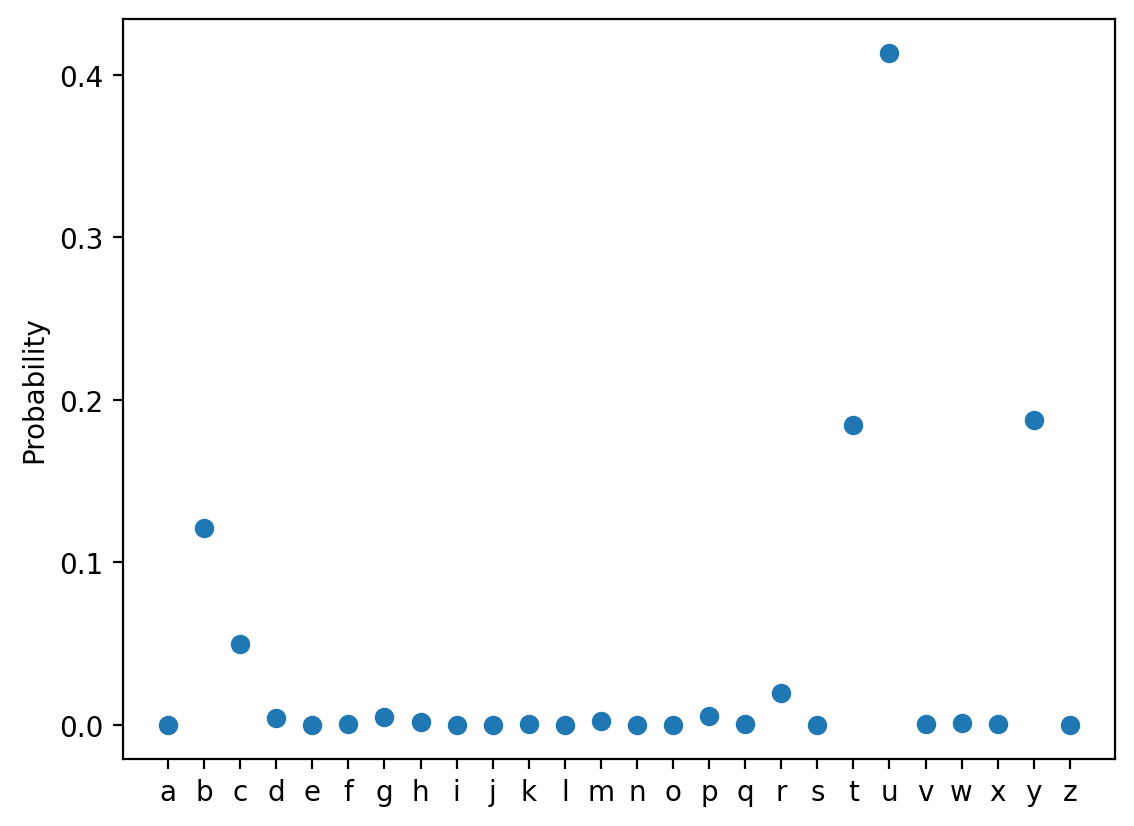

In [9]:
plt.scatter([chr(ord('a')+i) for i in range(26)],get_probs(model,'#nq#es#iona#l#').detach())
plt.ylabel('Probability')

### I masked u, t, y and b. The model seems to be predicting it accurately.

## Load testing words. Filter out words that are already in the training list

In [12]:
text_file = open(training_file,"r")
train_words = text_file.read().splitlines()
text_file.close()

text_file = open('testing_words.txt',"r", errors='ignore')
test_words = text_file.read().splitlines()
test_words = [word for word in test_words if word not in train_words and len(set(word)) > 1]
text_file.close()

## Test the accuracy

In [13]:
test_cases = random.sample(train_words,500)

In [14]:
won = 0; fails = []; wins=[]
for word in test_cases:
    if play(model,word,0):
        won += 1
        wins.append(word)
    else:
        fails.append(word)
print('accuracy = ', won/len(test_cases))

accuracy =  0.65


# The model achieved a 65% winning rate!!

### Plot a histogram to see accuracy vs word length

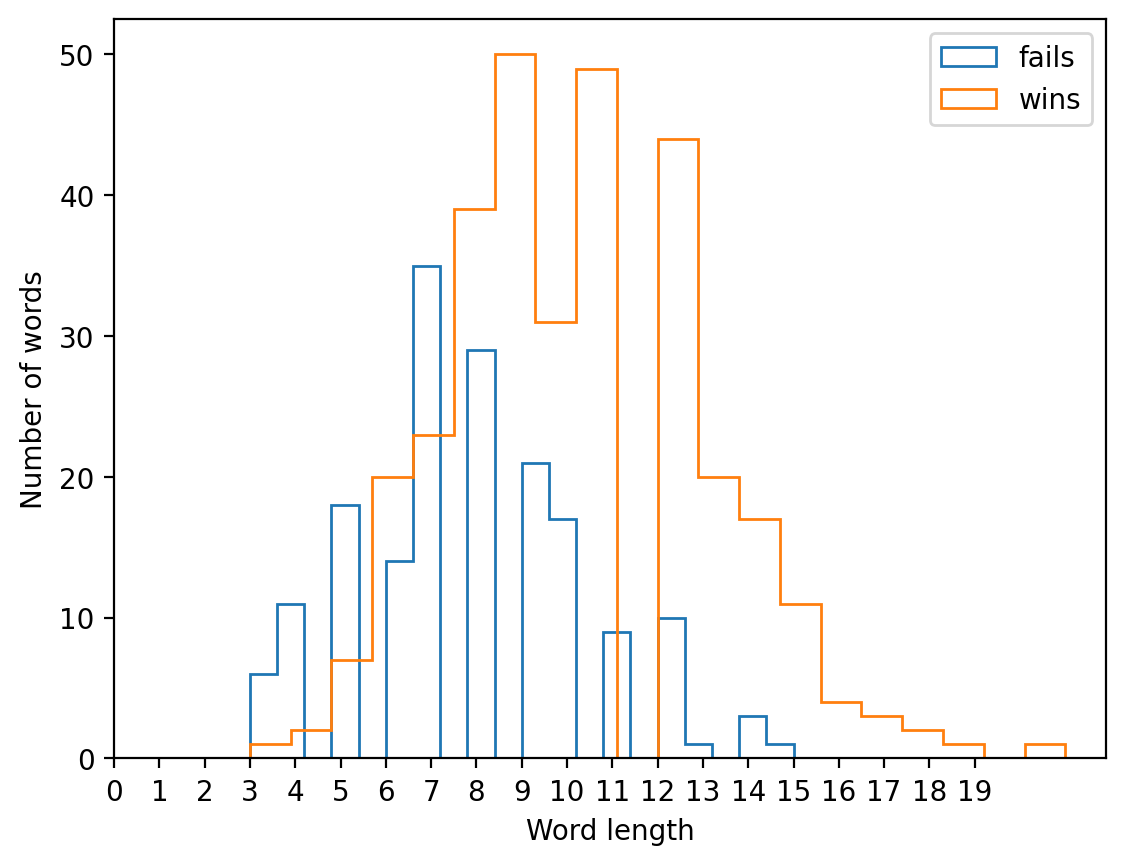

In [15]:
plt.hist([len(wrd) for wrd in fails], histtype='step',density=False,bins=20,label='fails')
plt.hist([len(wrd) for wrd in wins], histtype='step',density=False,bins=20,label='wins')
# plt.hist([len(wrd) for wrd in test_cases], histtype='step',density=True)
plt.xticks(range(20))
plt.legend()
plt.xlabel('Word length')
plt.ylabel('Number of words')
plt.show()


## Model does better on long words compared to short words